In [1]:
import warnings
warnings.simplefilter("ignore")

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# sns.set_style("darkgrid")
sns.set_style("whitegrid")

# plt.rc("figure", figsize=(16, 6))
plt.rc("figure", figsize=(10, 4))
# plt.rc("figure", figsize=(6, 3))

plt.rc("savefig", dpi=90)

# plt.rc("font", family="sans-serif")
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

# plt.rc("font", size=12)
plt.rc("font", size=10)
# plt.rc("font", size=9)

plt.rcParams["date.autoformatter.hour"] = "%H:%M:%S"

In [2]:
import os
import numpy as np
import pandas as pd


# src = '/Users/winston/mygitrep/sys23//cache/mlap_panel1.csv'
# src = '/Users/winston/mygitrep/sys23//cache/mlap_panel2.csv'
# src = '/Users/winston/mygitrep/sys23//cache/mlap_panel3.csv'
# src = '/Users/winston/mygitrep/sys23//cache/mlap_panel4.csv'
# src = '/Users/winston/mygitrep/sys23//cache/mlap_panel_d2d.csv'
src = '/Users/winston/mygitrep/sys23//cache/mlap_panel_m2010.csv'
dat = pd.read_csv(src, dtype={'stockcode': str}, index_col=[0, 1], parse_dates=['tradingdate'])
del src
dat.head()

R_0     R_1     R_2     R_3     R_4     R_5     R_6  \
tradingdate stockcode                                                           
2011-01-01  000001     0.0443 -0.0172 -0.1414  0.0397 -0.0667  0.0840 -0.0760   
            000002     0.0723  0.0305 -0.1936  0.0595  0.0046 -0.0838  0.0808   
            000005     0.0284 -0.0274 -0.1426 -0.1045 -0.0957 -0.0567  0.0774   
            000006     0.0948  0.0325 -0.0879 -0.1088 -0.0896 -0.1835  0.5887   
            000009     0.1337 -0.0028  0.2607  0.0152  0.0740  0.0285  0.0162   

                          R_7     R_8     R_9  ...   R_111   R_112   R_113  \
tradingdate stockcode                          ...                           
2011-01-01  000001    -0.0374 -0.0274 -0.0344  ... -0.0535  0.0405 -0.0655   
            000002     0.0244  0.0056 -0.1025  ... -0.0335  0.0777  0.0962   
            000005    -0.0376 -0.0175 -0.1199  ...  0.0801  0.0186 -0.0945   
            000006     0.0291 -0.0548 -0.1283  ... -0.0319  0.0195  0.0358   
            000009    -0.0429 -0.0482  0.0184  ...  0.0180 -0.0829 -0.0414   

                        R_114   R_115   R_116   R_117   R_118   R_119   R_120  
tradingdate stockcode                                                          
2011-01-01  000001    -0.0073 -0.0382  0.0659  0.0127  0.0457 -0.0607 -0.0674  
            000002     0.0710  0.0324 -0.0765 -0.0321  0.0135 -0.0056  0.0812  
            000005     0.0553  0.0232 -0.0424 -0.0104 -0.0026 -0.0103 -0.0074  
            000006     0.0827 -0.0113 -0.0769  0.0279 -0.0158  0.0269  0.0519  
            000009     0.0017 -0.0518 -0.0750  0.0205 -0.0213  0.1264 -0.0201  

[5 rows x 121 columns]

In [3]:
# 面板: 包含一阶、二阶、三阶矩
panel = [] 

# df = dat.loc[:, 'R_0':'R_119'] ** 2
df = dat.loc[:, 'R_1':'R_120'] ** 2
df.columns = [x.replace('R_', 'R2_') for x in df.columns]
panel.append(df)

# df = dat.loc[:, 'R_0':'R_119']**3
df = dat.loc[:, 'R_1':'R_120'] ** 3
df.columns = [x.replace('R_', 'R3_') for x in df.columns]
panel.append(df)
del df

panel = pd.concat([dat] + panel, axis=1)
del dat
panel.index.names = ['tradingdate', 'stockcode']
panel.columns = ['ExRtn1d'] + [f"{x.split('_')[0]}_{int(x.split('_')[-1])-1}" for x in panel.columns[1:]]

## 基于历史数据的简单收益率预测模型

$$
\mathrm{E} [r_{i, t+1} | \mathbf{x}_{i,t}] f(\mathbf{x}_{i,t})
$$

聚焦：横截面（cross-section）差异。

$r_{i}$: 以市场指数为基准的相对收益。

模型一：仅加入历史已实现收益率。也能产生大量预测变量，得到高维预测问题。

$$
r_{i, t+1} = \sum_{k=1}^{119} b_{k} r_{i,t-k}
 + \sum_{k=1}^{119} c_{k} r_{i, t-k}^2 
 + \sum_{k=1}^{119} d_{k} r_{i, t-k}^3 
 + e_{i, t+1}
$$

* 周度收益率，过去 120 周预测下 1 周；留 1 法，留出每 12 周做 CV
* 排除小市值/壳污染：市值高于20%分位数；每股价格 1 以上

+ 自变量/因变量预处理：截面去均值
+ 截面上：自变量标准化，每月截面标准差为 1
+ 非均衡面板（每期观测数不一）：
$$
\mathrm{mse} = \frac{1}{T-1} \sum_{t=1}^{T-1} \sum_{i=1}^{N_t} \frac{ (r_{i, t+1} - f( \mathbf{x}_{i,t}))^2 }{N_{t}}
$$

## 训练数据准备

In [4]:
panel.head()

ExRtn1d     R_0     R_1     R_2     R_3     R_4  \
tradingdate stockcode                                                    
2011-01-01  000001      0.0443 -0.0172 -0.1414  0.0397 -0.0667  0.0840   
            000002      0.0723  0.0305 -0.1936  0.0595  0.0046 -0.0838   
            000005      0.0284 -0.0274 -0.1426 -0.1045 -0.0957 -0.0567   
            000006      0.0948  0.0325 -0.0879 -0.1088 -0.0896 -0.1835   
            000009      0.1337 -0.0028  0.2607  0.0152  0.0740  0.0285   

                          R_5     R_6     R_7     R_8  ...    R3_110  \
tradingdate stockcode                                  ...             
2011-01-01  000001    -0.0760 -0.0374 -0.0274 -0.0344  ... -0.000153   
            000002     0.0808  0.0244  0.0056 -0.1025  ... -0.000038   
            000005     0.0774 -0.0376 -0.0175 -0.1199  ...  0.000514   
            000006     0.5887  0.0291 -0.0548 -0.1283  ... -0.000032   
            000009     0.0162 -0.0429 -0.0482  0.0184  ...  0.000006   

                         R3_111    R3_112        R3_113    R3_114    R3_115  \
tradingdate stockcode                                                         
2011-01-01  000001     0.000066 -0.000281 -3.890170e-07 -0.000056  0.000286   
            000002     0.000469  0.000890  3.579110e-04  0.000034 -0.000448   
            000005     0.000006 -0.000844  1.691124e-04  0.000012 -0.000076   
            000006     0.000007  0.000046  5.656093e-04 -0.000001 -0.000455   
            000009    -0.000570 -0.000071  4.913000e-09 -0.000139 -0.000422   

                         R3_116        R3_117        R3_118        R3_119  
tradingdate stockcode                                                      
2011-01-01  000001     0.000002  9.544399e-05 -2.236485e-04 -3.061820e-04  
            000002    -0.000033  2.460375e-06 -1.756160e-07  5.353873e-04  
            000005    -0.000001 -1.757600e-08 -1.092727e-06 -4.052240e-07  
            000006     0.000022 -3.944312e-06  1.946511e-05  1.397984e-04  
            000009     0.000009 -9.663597e-06  2.019488e-03 -8.120601e-06  

[5 rows x 361 columns]

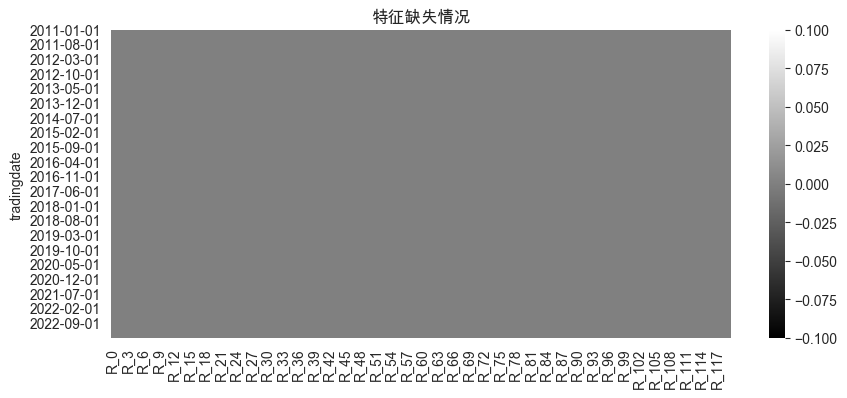

In [5]:
# 自变量缺失情况
df = panel.loc[:, 'R_0':'R_119'].isna().groupby(panel.index.get_level_values('tradingdate')).mean()
df.index = df.index.strftime('%Y-%m-%d')

# 使用seaborn库的heatmap函数绘制热力图
sns.heatmap(df, cmap='gray')

# 显示热力图
plt.title('特征缺失情况')
plt.show()

In [6]:
# target, features = panel.loc[:, 'ExRtn5D'], panel.loc[:, 'R_0':]
target, features = panel.loc[:, 'ExRtn1d'], panel.loc[:, 'R_0':]
print(target.shape, features.shape)

td0 = target.index.get_level_values('tradingdate')
td1 = td0.unique()
print(len(td1))

(131303,) (131303, 360)
147


In [7]:
# 因变量 (1)截面去均值 (2) 标准化
target = target.sub(target.groupby(td0).mean())
# target = target.div(target.groupby(td0).std())

# 自变量 (1)截面去均值 (3)填充缺失 (2)标准化
features = features.sub(features.groupby(td0).mean())
features = features.fillna(0)
features = features.div(features.groupby(td0).std())

### 训练（验证）集；测试集合

In [8]:
gn = np.array([x // 12 for x in range(len(td1))])

# 验证集
is_test = td0 >= td1[gn == gn.max() - 2].min()
y_train, y_test = target[~is_test], target[is_test]
x_train, x_test = features[~is_test], features[is_test]

In [9]:
print(len(y_train), len(y_test))

95862 35441


## 模型训练

### 公共函数

In [10]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV

# 自定义交叉验证生成器
def custom_cv_generator(td, d0='2010-12-31', unit=12):
    td1 = td.unique()
    n_unq_tds = len(td1)
    print(f"共有 {n_unq_tds} ；\n"
          f"根据留 1 法，每 {unit} 期为一组，共 {n_unq_tds // unit} 组，余 {n_unq_tds % unit} 期作为测试集")
    for d1 in td1[unit-1::unit]:
        is_val = (d0 < td) & (td <= d1)
        is_train = ~is_val
        
        yield is_train, is_val
        d0 = d1

# 自定义损失函数
def custom_scoring(kind=3, yscale=12):

    def func(y_true, y_pred):
        _td = y_true.index.get_level_values('tradingdate')
        w = pd.Series(y_pred, index=y_true.index).groupby(_td).apply(lambda s: s / s.abs().sum())
        r = (w * y_true).groupby(_td).sum()
        
        mu = r.mean() * yscale
        if kind == 1:
            return mu
        
        sig = r.std() * np.sqrt(yscale)
        if kind == 2:
            return sig
        
        return mu / sig

    return func

# 定义评估指标字典
scoring = {
    'MSE': 'neg_mean_squared_error', 
    'R2': 'r2',
    'Mu': make_scorer(custom_scoring(1), greater_is_better=True),
    'Sigma': make_scorer(custom_scoring(2), greater_is_better=True),
    'Sharpe': make_scorer(custom_scoring(3), greater_is_better=True),
}

**评估指标**

1. 样本内 $R^2$
2. 交叉验证 $R^2$
3. 交叉验证投资组合收益率 $r_p$
    * 均值
    * 标准差
    * 夏普比率
    
**投资组合构建**

$$
\hat{\omega}_{t-1} = \frac{1}{\sum_{i=1}^{N} |\hat{\mu}_{i, t-1}|}{\hat{\mathbf{\mu}}_{t-1}}
$$


### I. OLS

In [11]:
# 建立简单的 OLS 模型，用所有训练集数据
ols_reg = sm.OLS(y_train, x_train).fit()
# ols_reg.summary()

# 计算样本内指标
y_train_pred = ols_reg.predict(x_train)
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = ols_reg.rsquared

# 计算样本外指标
y_test_pred = ols_reg.predict(x_test)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# 创建指标表格
data = {'指标': ['MSE', 'MAE', 'R2'],
        '样本内': [mse_train, mae_train, r2_train],
        '样本外': [mse_test, mae_test, r2_test]}
train_res_ols = pd.DataFrame(data)

# 打印指标表格
print(train_res_ols.round(4))

    指标     样本内     样本外
0  MSE  0.0110  0.0152
1  MAE  0.0689  0.0797
2   R2  0.0102  0.0007


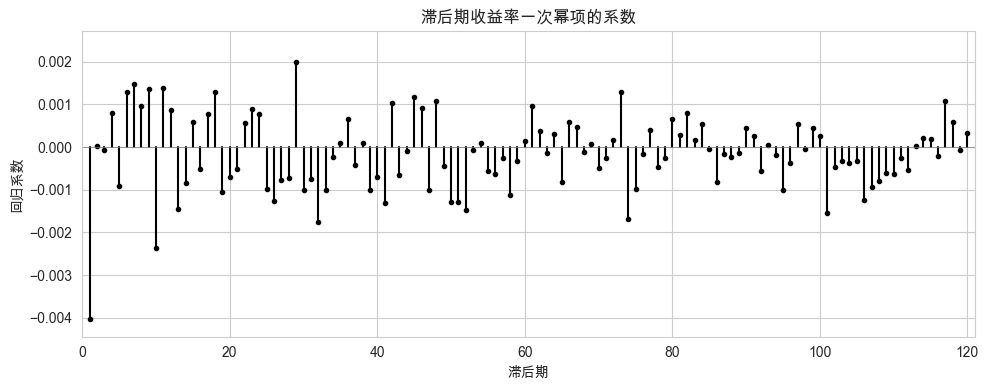

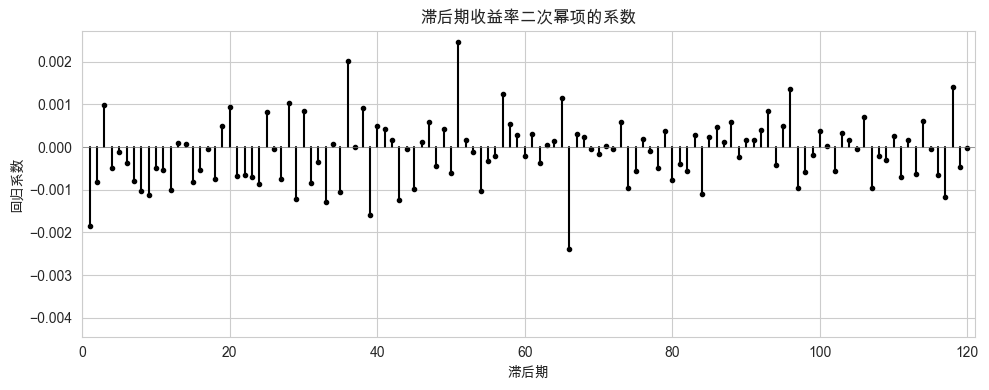

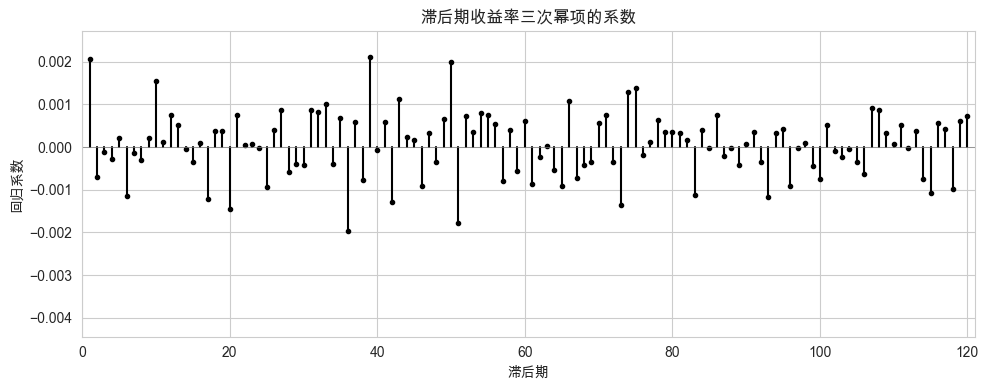

In [12]:
# 绘制估计系数规模
def plot_coefficiet_scales(coefficients):
    coefficients = coefficients.values if isinstance(coefficients, pd.Series) else coefficients
    for i, l in zip(range(0, len(coefficients), 120), ['一', '二', '三']):
        plt.scatter(range(1, 121), coefficients[i: i+120], color='k', marker='.')

        # 绘制点到x轴的连线
        for j in range(1, 121):
            plt.plot([j, j], [0, coefficients[j+i-1]], color='k', linestyle='-')

        plt.ylim((coefficients[:].min() * 1.1, coefficients[:].max() * 1.1))
        plt.xlim((0, 121))
        plt.axhline(y=0, color='gray', linewidth=.5)
        plt.title(f'滞后期收益率{l}次幂项的系数', size=12)
        plt.xlabel('滞后期')
        plt.ylabel('回归系数')
        plt.tight_layout()
        plt.grid(True)
        plt.show()

    
# 绘制 OLS 全训练样本内估计系数规模
plot_coefficiet_scales(ols_reg.params.values)

In [13]:
# 评估OLS回归模型 CV 表现
ols = LinearRegression()

# 自定义交叉验证生成器
cvg = custom_cv_generator(td=y_train.index.get_level_values('tradingdate'), unit=12)

# CV
cv_scores_ols = cross_validate(ols, x_train, y_train, cv=cvg, scoring=scoring, verbose=1, return_train_score=True)

cv_res_ols = pd.DataFrame(cv_scores_ols).mean()
print(cv_res_ols.round(3))

共有 120 ；
根据留 1 法，每 12 期为一组，共 10 组，余 0 期作为测试集


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


fit_time        1.645
score_time      0.037
test_MSE       -0.011
train_MSE      -0.011
test_R2        -0.008
train_R2        0.011
test_Mu         0.039
train_Mu        0.175
test_Sigma      0.039
train_Sigma     0.053
test_Sharpe     1.102
train_Sharpe    3.346
dtype: float64


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.7s finished


### II. Ridge

**超参数**: $\gamma$

**交叉验证依据（OLS不适用）**

1. $R^2$
2. $\mathrm{E}[r_p]$

**缩放比例**

1. 相同
2. 不同

### II(1) Ridge + No Rescale + R2

共有 120 ；
根据留 1 法，每 12 期为一组，共 10 组，余 0 期作为测试集
Fitting 10 folds for each of 4 candidates, totalling 40 fits
|                   |   500000.0 |
|:------------------|-----------:|
| mean_test_MSE     |     -0.011 |
| mean_train_MSE    |     -0.011 |
| mean_test_R2      |      0.001 |
| mean_train_R2     |      0.003 |
| mean_test_Mu      |      0.04  |
| mean_train_Mu     |      0.152 |
| mean_test_Sigma   |      0.042 |
| mean_train_Sigma  |      0.048 |
| mean_test_Sharpe  |      1.177 |
| mean_train_Sharpe |      3.165 |
| best_alpha        | 500000     |


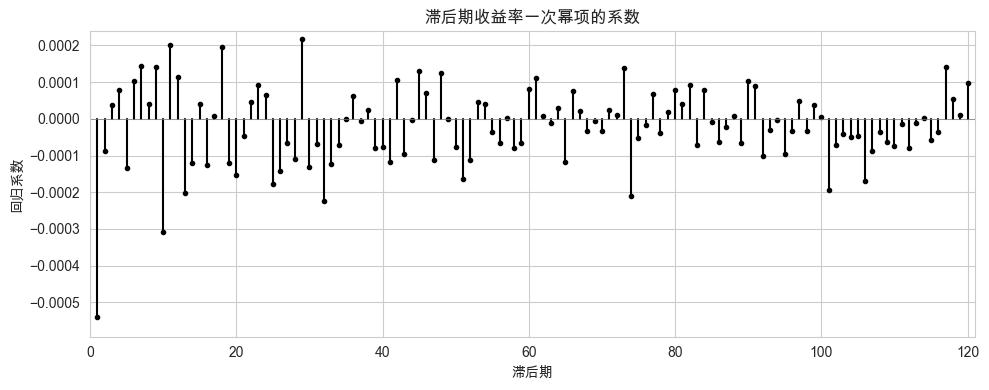

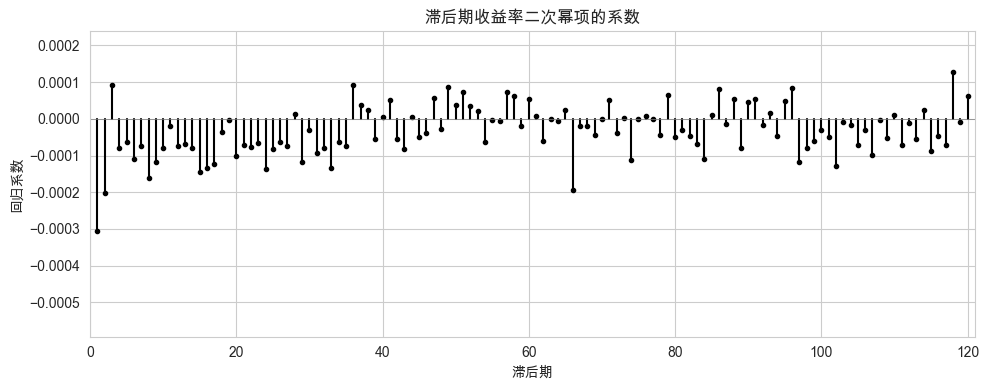

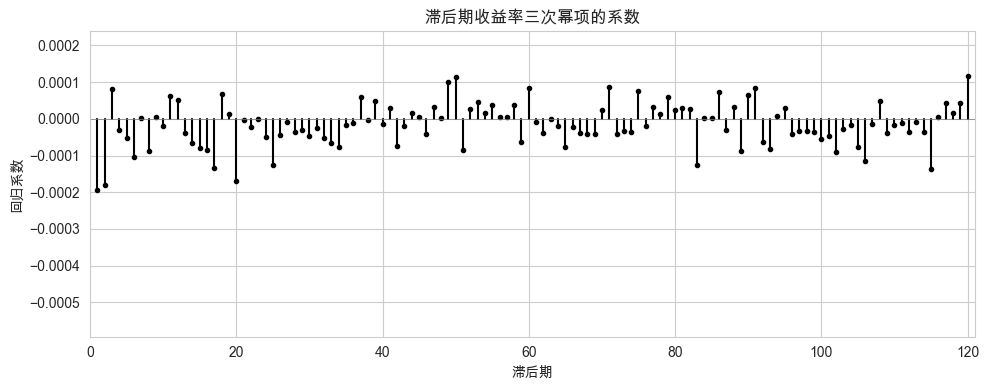

In [14]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# 创建Ridge回归模型
ridge = Ridge()

# 定义超参数候选列表
# param_grid = {'alpha': [1, 1e2, 1e4, 1e6]}  # 1e6
# param_grid = {'alpha': [1e5, 1e6, 1e7, 1e8]}  # 1e6
param_grid = {'alpha': [5e5, 1e6, 2e6, 5e6]}  #

# 自定义交叉验证生成器
cvg = custom_cv_generator(td=y_train.index.get_level_values('tradingdate'), unit=12)

# 创建GridSearchCV对象，并传递自定义交叉验证生成器
grid_search_1 = GridSearchCV(
    ridge, param_grid, 
    cv=cvg,
    scoring=scoring,
    refit='R2',  # 设置要优化的评估指标为R2
    return_train_score=True,  # 记录训练集性能指标
    verbose=1
)

# 使用训练数据拟合GridSearchCV对象
grid_search_1.fit(x_train, y_train)


# 输出交叉验证结果
cv_scores_ridge_1 = grid_search_1.cv_results_
cv_results_ridge_1 = pd.DataFrame(cv_scores_ridge_1)

cv_res_ridge_1 = cv_results_ridge_1.set_index('param_alpha').loc[
    grid_search_1.best_params_['alpha'], 
    ['mean_test_MSE', 'mean_train_MSE',  
     'mean_test_R2', 'mean_train_R2', 
     'mean_test_Mu', 'mean_train_Mu', 
     'mean_test_Sigma', 'mean_train_Sigma', 
     'mean_test_Sharpe','mean_train_Sharpe']
]
cv_res_ridge_1['best_alpha'] = grid_search_1.best_params_['alpha']

print(cv_res_ridge_1.astype(float).round(3).to_markdown())


# 绘制样本内估计系数规模
plot_coefficiet_scales(grid_search_1.best_estimator_.coef_)

### II(2). Ridge + No Rescale + Sharpe

共有 120 ；
根据留 1 法，每 12 期为一组，共 10 组，余 0 期作为测试集
Fitting 10 folds for each of 4 candidates, totalling 40 fits
|                   |   100000.0 |
|:------------------|-----------:|
| mean_test_MSE     |     -0.011 |
| mean_train_MSE    |     -0.011 |
| mean_test_R2      |     -0     |
| mean_train_R2     |      0.007 |
| mean_test_Mu      |      0.041 |
| mean_train_Mu     |      0.163 |
| mean_test_Sigma   |      0.042 |
| mean_train_Sigma  |      0.051 |
| mean_test_Sharpe  |      1.178 |
| mean_train_Sharpe |      3.262 |
| best_alpha        | 100000     |


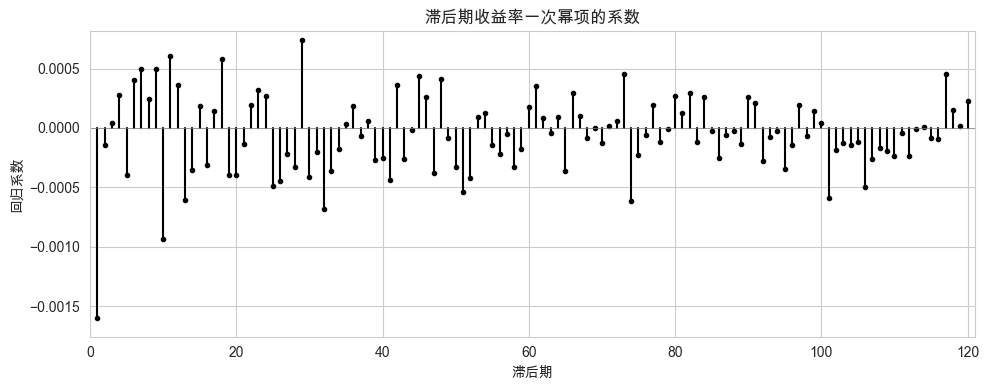

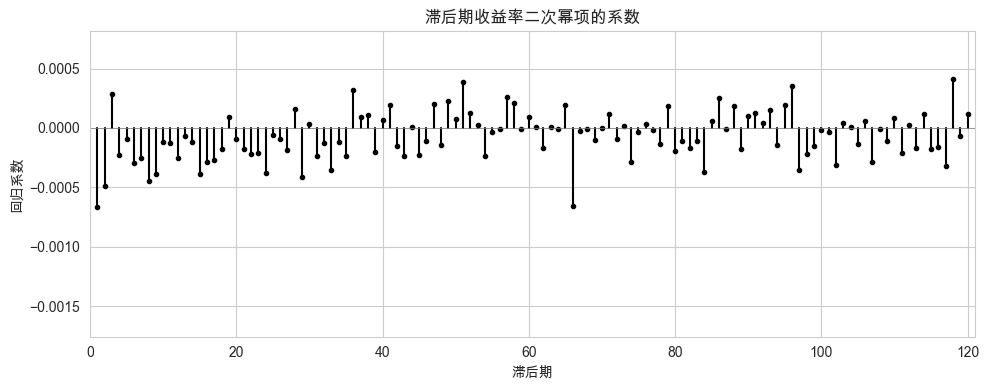

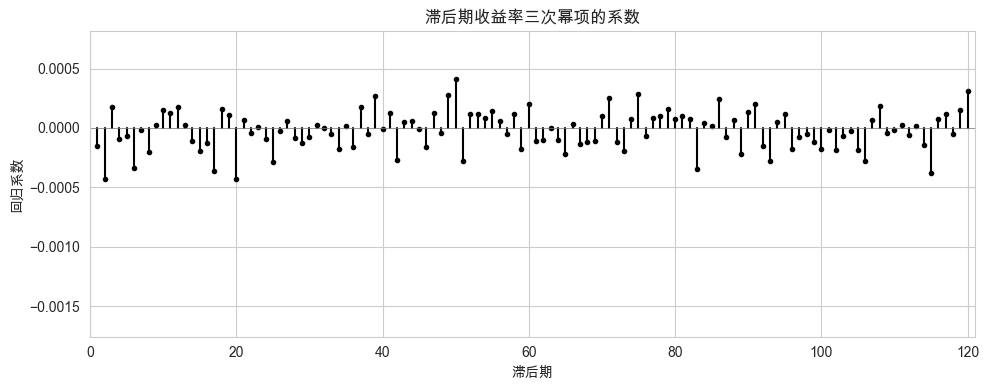

In [15]:
# 创建Ridge回归模型
ridge = Ridge()

# 定义超参数候选列表
# param_grid = {'alpha': [1, 1e2, 1e4, 1e6]}  # 1e6
# param_grid = {'alpha': [1e5, 1e6, 1e7, 1e8]}  # 1e5
param_grid = {'alpha': [1e4, 5e4, 1e5, 5e5]}

# 自定义交叉验证生成器
cvg = custom_cv_generator(td=y_train.index.get_level_values('tradingdate'), unit=12)

# 创建GridSearchCV对象，并传递自定义交叉验证生成器
grid_search_2 = GridSearchCV(
    ridge, param_grid, 
    cv=cvg,
    scoring=scoring,
    # refit='R2',  # 设置要优化的评估指标
    # refit='Mu',  # 设置要优化的评估指标
    refit='Sharpe',  # 设置要优化的评估指标
    return_train_score=True,  # 记录训练集性能指标
    verbose=1
)

# 使用训练数据拟合GridSearchCV对象
grid_search_2.fit(x_train, y_train)


# 输出交叉验证结果
cv_scores_ridge_2 = grid_search_2.cv_results_
cv_results_ridge_2 = pd.DataFrame(cv_scores_ridge_2)

cv_res_ridge_2 = cv_results_ridge_2.set_index('param_alpha').loc[
    grid_search_2.best_params_['alpha'], 
    ['mean_test_MSE', 'mean_train_MSE',  
     'mean_test_R2', 'mean_train_R2', 
     'mean_test_Mu', 'mean_train_Mu', 
     'mean_test_Sigma', 'mean_train_Sigma', 
     'mean_test_Sharpe','mean_train_Sharpe']
]
cv_res_ridge_2['best_alpha'] = grid_search_2.best_params_['alpha']

print(cv_res_ridge_2.astype(float).round(3).to_markdown())


# 绘制样本内估计系数规模
plot_coefficiet_scales(grid_search_2.best_estimator_.coef_)

### Ridge + 引入先验

**DGP**

$$
\mathbf{r}_t = \mathbf{\mu} + \varepsilon_t, \\
\mathbf{\mu} = \mathbf{X} \mathbf{g} .
$$


参数估计

$$
\hat{\mathbf{g}}
= \left(
\mathbf{X}' \mathbf{X} + \gamma \mathbf{I}_{K}
\right)^{-1} \mathbf{X}' \bar{\mathbf{r}}.
$$

Assume  $ \mathbf{X}' \mathbf{X} = \mathbf{I}_{K} $, then we have

$$
\hat{\mathbf{g}} = \frac{1}{1 + \gamma} \mathbf{X}' \bar{\mathbf{r}}
$$

> 正则化后即使样本外 R2 提升，也无法保证投资组合的样本外表现同样会提升。为使参数收缩起作用，需要保留 $\mathbf{X}$ 正交后的截面标准差

对 $\mathbf{X}'\mathbf{X}$ 进行特征分解 $\mathbf{X}'\mathbf{X}=\mathbf{Q} \mathbf{\Lambda} \mathbf{Q}'$

$$
\mathbf{X} = \mathbf{Q}_{K} \mathbf{\Lambda}_{K}^{\frac{1}{2}} \\
\mathbf{Q}_{K}' \mathbf{Q}_{K} = \mathbf{I}_{K} \\
\mathbf{X}' \mathbf{X} = \mathbf{\Lambda}_{K} \\
\Rightarrow\quad
\hat{\mathbf{g}}_{OLS} = \mathbf{\Lambda}_{K}^{-\frac{1}{2}} \mathbf{Q}_{K}' \bar{\mathbf{r}}
$$

> 截面方差较小的预测变量，给予更大程度的收缩，因为它们贡献了更多的估计误差

* 协变量尺度缩放会影响岭回归中收缩的作用
* 先验知识：某些协变量不如另一些重要
* 正太分布先验：回归系数的先验方差矩阵/随机扰动的协方差矩阵 均正比于单位矩阵
* 引入先验：不确定历史收益率与未来收益率的非线性关系，重新缩放二次项/三次项——标准化后缩放方差到 1/2, 1/4

**先验确定缩放尺度**

+ 基于某协变量构造的投资组合，如果具有较高的收益率，那么该投资组合的波动率也较大
+ 主成分投资组合：协变量向量为收益率协方差矩阵前 K 个特征向量 $\mathbf{X} = \mathbf{Q}_K$, $\mathbf{\Sigma} \approx \mathbf{Q}_K \mathbf{\Lambda}_K \mathbf{Q}_K'$
+ 夏普比率高的主成分投资组合波动率越大（Kozak, Nagel, & Santosh, 2018），先验分布

$$
\mathbf{g} \sim \mathrm{N}\left(\mathbf{0}, \gamma^{-1} \mathbf{\Lambda}_K^2 \right),\quad 0\le\gamma\le 1\\
\mathbf{\Lambda}_K = \mathrm{var}\left(\mathbf{Q}_K' \mathbf{r}_t\right),\\
\mathbf{g} = \mathrm{E}\left[\mathbf{Q}_K' \mathbf{r}_t\right].
$$

+ 此时，夏普比率满足先验分布

$$
\mathbf{\Lambda}_{K}^{-1/2} \mathbf{g} \sim \mathrm{N}\left(\mathbf{0}, \gamma^{-1} \mathbf{\Lambda}_K\right)
$$

In [16]:
def rescale_120_rtns(df0):
    df = df0.copy()
    df.iloc[:, 120:240] = df.iloc[:, 120:240] / 2
    df.iloc[:, 240:360] = df.iloc[:, 240:360] / 4
    return df

x_train_rs = rescale_120_rtns(x_train)

### II(3) Ridge + Rescale + R2

共有 120 ；
根据留 1 法，每 12 期为一组，共 10 组，余 0 期作为测试集
Fitting 10 folds for each of 4 candidates, totalling 40 fits
|                   |   100000.0 |
|:------------------|-----------:|
| mean_test_MSE     |     -0.011 |
| mean_train_MSE    |     -0.011 |
| mean_test_R2      |      0.001 |
| mean_train_R2     |      0.005 |
| mean_test_Mu      |      0.042 |
| mean_train_Mu     |      0.144 |
| mean_test_Sigma   |      0.043 |
| mean_train_Sigma  |      0.051 |
| mean_test_Sharpe  |      1.239 |
| mean_train_Sharpe |      2.845 |
| best_alpha        | 100000     |


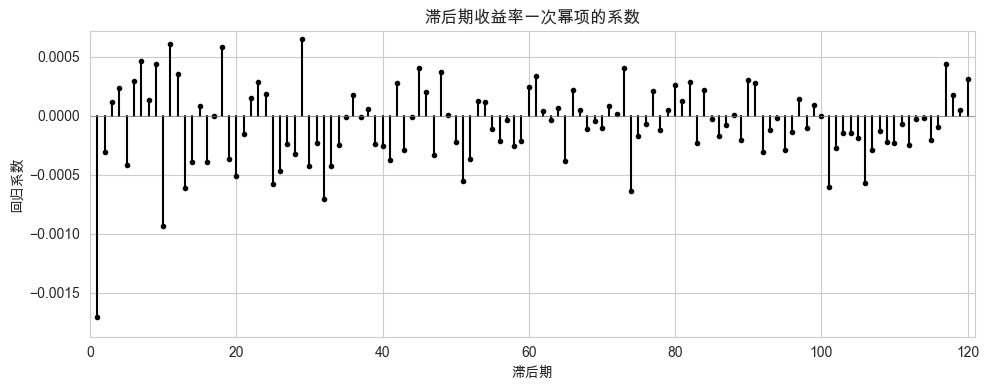

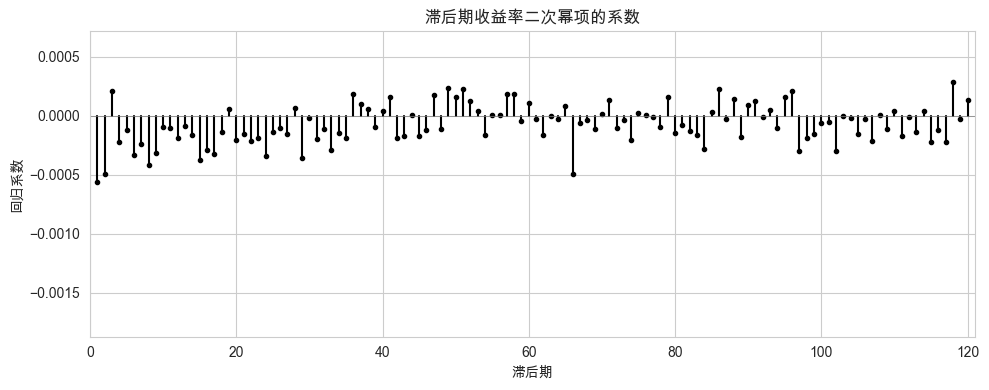

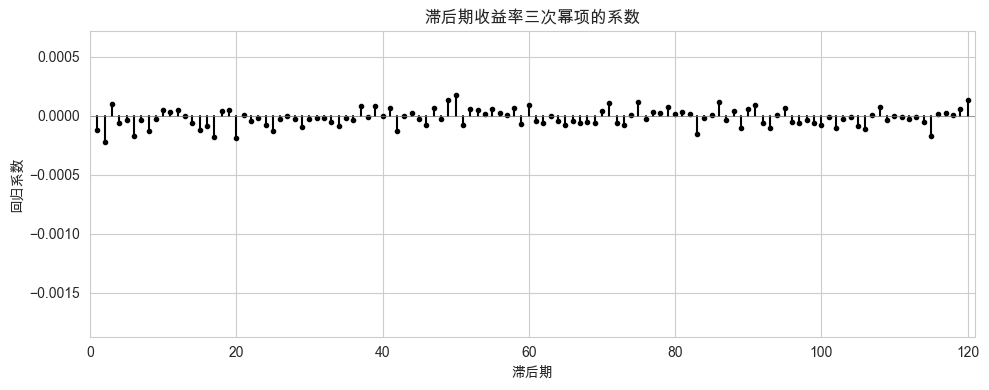

In [17]:
# 创建Ridge回归模型
ridge = Ridge()

# 定义超参数候选列表
# param_grid = {'alpha': [1, 1e2, 1e4, 1e6]}  # 1e6
# param_grid = {'alpha': [1e5, 1e6, 1e7, 1e8]}  # 1e5
param_grid = {'alpha': [1e4, 5e4, 1e5, 5e5]}

# 自定义交叉验证生成器
cvg = custom_cv_generator(td=y_train.index.get_level_values('tradingdate'), unit=12)

# 创建GridSearchCV对象，并传递自定义交叉验证生成器
grid_search_3 = GridSearchCV(
    ridge, param_grid, 
    cv=cvg,
    scoring=scoring,
    refit='R2',  # 设置要优化的评估指标
    # refit='Mu',  # 设置要优化的评估指标
    return_train_score=True,  # 记录训练集性能指标
    verbose=1
)

# 使用训练数据拟合GridSearchCV对象
grid_search_3.fit(x_train_rs, y_train)
# grid_search_3.fit(x_train, y_train)


# 输出交叉验证结果
cv_scores_ridge_3 = grid_search_3.cv_results_
cv_results_ridge_3 = pd.DataFrame(cv_scores_ridge_3)

cv_res_ridge_3 = cv_results_ridge_3.set_index('param_alpha').loc[
    grid_search_3.best_params_['alpha'], 
    ['mean_test_MSE', 'mean_train_MSE',  
     'mean_test_R2', 'mean_train_R2', 
     'mean_test_Mu', 'mean_train_Mu', 
     'mean_test_Sigma', 'mean_train_Sigma', 
     'mean_test_Sharpe','mean_train_Sharpe']
]
cv_res_ridge_3['best_alpha'] = grid_search_3.best_params_['alpha']

print(cv_res_ridge_3.astype(float).round(3).to_markdown())


# 绘制样本内估计系数规模
plot_coefficiet_scales(grid_search_3.best_estimator_.coef_)

### II(4) Ridge + Rescale + Sharpe

共有 120 ；
根据留 1 法，每 12 期为一组，共 10 组，余 0 期作为测试集
Fitting 10 folds for each of 4 candidates, totalling 40 fits
|                   |   500000.0 |
|:------------------|-----------:|
| mean_test_MSE     |     -0.011 |
| mean_train_MSE    |     -0.011 |
| mean_test_R2      |      0.001 |
| mean_train_R2     |      0.002 |
| mean_test_Mu      |      0.041 |
| mean_train_Mu     |      0.138 |
| mean_test_Sigma   |      0.043 |
| mean_train_Sigma  |      0.051 |
| mean_test_Sharpe  |      1.245 |
| mean_train_Sharpe |      2.76  |
| best_alpha        | 500000     |


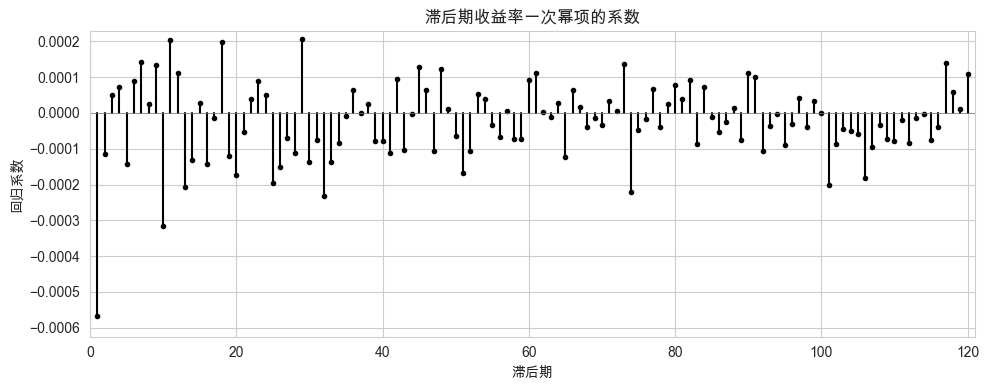

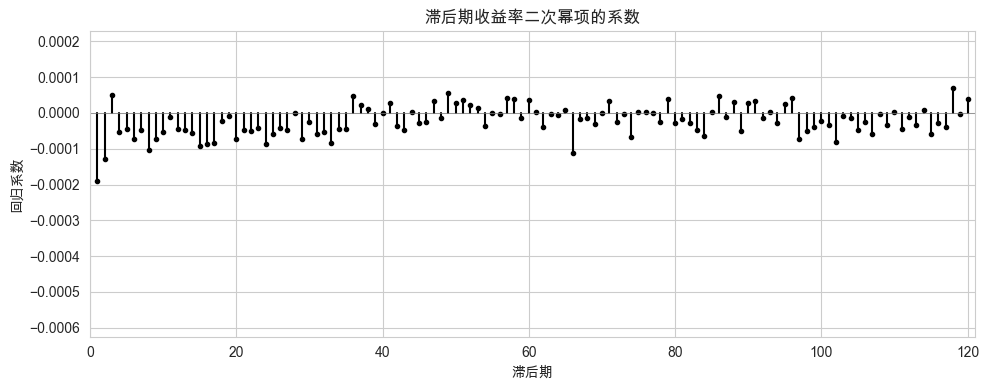

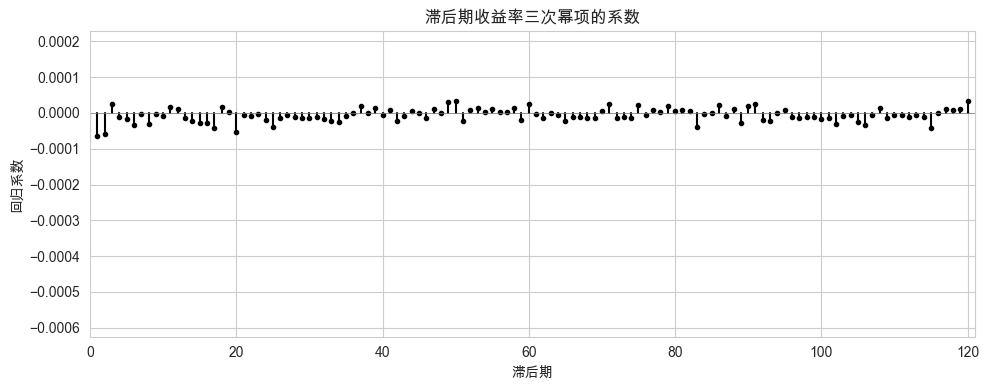

In [18]:
# 创建Ridge回归模型
ridge = Ridge()

# 定义超参数候选列表
# param_grid = {'alpha': [1, 1e2, 1e4, 1e6]}  # 1e6
# param_grid = {'alpha': [1e5, 1e6, 1e7, 1e8]}  # 1e5
param_grid = {'alpha': [1e4, 5e4, 1e5, 5e5]}

# 自定义交叉验证生成器
cvg = custom_cv_generator(td=y_train.index.get_level_values('tradingdate'), unit=12)

# 创建GridSearchCV对象，并传递自定义交叉验证生成器
grid_search_4 = GridSearchCV(
    ridge, param_grid, 
    cv=cvg,
    scoring=scoring,
    # refit='R2',  # 设置要优化的评估指标
    # refit='Mu',  # 设置要优化的评估指标
    refit='Sharpe',  # 设置要优化的评估指标
    return_train_score=True,  # 记录训练集性能指标
    verbose=1
)

# 使用训练数据拟合GridSearchCV对象
grid_search_4.fit(x_train_rs, y_train)
# grid_search_4.fit(x_train, y_train)


# 输出交叉验证结果
cv_scores_ridge_4 = grid_search_4.cv_results_
cv_results_ridge_4 = pd.DataFrame(cv_scores_ridge_4)

cv_res_ridge_4 = cv_results_ridge_4.set_index('param_alpha').loc[
    grid_search_4.best_params_['alpha'], 
    ['mean_test_MSE', 'mean_train_MSE',  
     'mean_test_R2', 'mean_train_R2', 
     'mean_test_Mu', 'mean_train_Mu', 
     'mean_test_Sigma', 'mean_train_Sigma', 
     'mean_test_Sharpe','mean_train_Sharpe']
]
cv_res_ridge_4['best_alpha'] = grid_search_4.best_params_['alpha']

print(cv_res_ridge_4.astype(float).round(3).to_markdown())


# 绘制样本内估计系数规模
plot_coefficiet_scales(grid_search_4.best_estimator_.coef_)

### III. LASSO

共有 120 ；
根据留 1 法，每 12 期为一组，共 10 组，余 0 期作为测试集
Fitting 10 folds for each of 11 candidates, totalling 110 fits
|                   |   5e-05 |
|:------------------|--------:|
| mean_test_MSE     |  -0.011 |
| mean_train_MSE    |  -0.011 |
| mean_test_R2      |  -0.005 |
| mean_train_R2     |   0.01  |
| mean_test_Mu      |   0.039 |
| mean_train_Mu     |   0.166 |
| mean_test_Sigma   |   0.042 |
| mean_train_Sigma  |   0.053 |
| mean_test_Sharpe  |   1.087 |
| mean_train_Sharpe |   3.164 |
| best_alpha        |   0     |


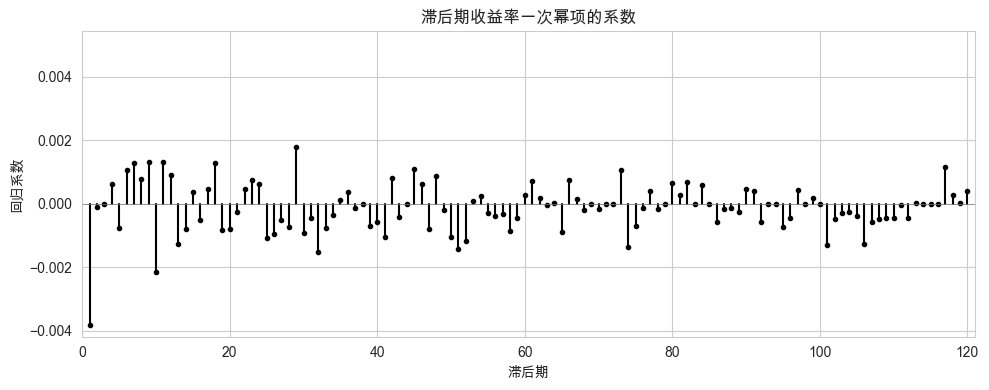

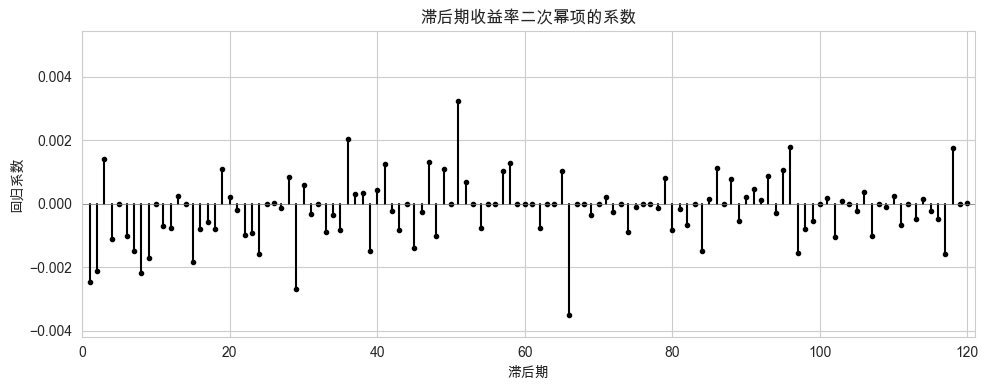

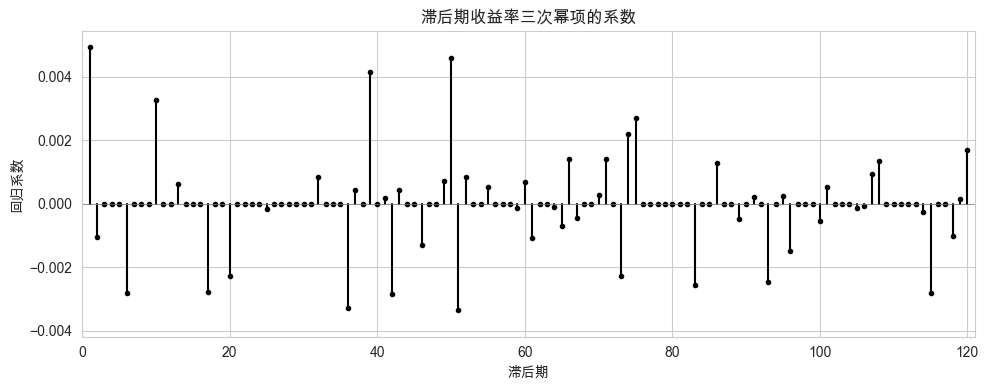

In [19]:
from sklearn.linear_model import Lasso

# 创建Lasso回归模型
lasso = Lasso()

# 定义超参数候选列表
# param_grid = {'alpha': [1e-4, 1e-2, 1, 10]}  # 1e-4
# param_grid = {'alpha': [1e-6, 1e-5, 1e-4, 1e-3]}  # 1e-4
# param_grid = {'alpha': [5e-5, 1e-4, 2e-4, 5e-4]}  # 5e-5
# param_grid = {'alpha': [2e-5, 3e-5, 4e-5, 5e-5, 6e-5, 7e-5, 8e-5]}  # 4e-5
param_grid = {'alpha': np.linspace(3e-5, 5e-5, 11)}

# 自定义交叉验证生成器
cvg = custom_cv_generator(td=y_train.index.get_level_values('tradingdate'), unit=12)

# 创建GridSearchCV对象，并传递自定义交叉验证生成器
grid_search_lasso = GridSearchCV(
    lasso, param_grid,
    cv=cvg,
    scoring=scoring,
    # refit='Mu',  # 设置要优化的评估指标
    # refit='R2',  # 设置要优化的评估指标
    refit='Sharpe',  # 设置要优化的评估指标
    return_train_score=True,  # 记录训练集性能指标
    verbose=1
)

# 使用训练数据拟合GridSearchCV对象
grid_search_lasso.fit(x_train_rs, y_train)
# grid_search_lasso.fit(x_train, y_train)

# 输出交叉验证结果
cv_scores_lasso = grid_search_lasso.cv_results_
cv_results_lasso = pd.DataFrame(cv_scores_lasso)

cv_res_lasso = cv_results_lasso.set_index('param_alpha').loc[
    grid_search_lasso.best_params_['alpha'],
    ['mean_test_MSE', 'mean_train_MSE',
     'mean_test_R2', 'mean_train_R2',
     'mean_test_Mu', 'mean_train_Mu',
     'mean_test_Sigma', 'mean_train_Sigma',
     'mean_test_Sharpe', 'mean_train_Sharpe']
]
cv_res_lasso['best_alpha'] = grid_search_lasso.best_params_['alpha']

print(cv_res_lasso.astype(float).round(3).to_markdown())


# 绘制样本内估计系数规模
plot_coefficiet_scales(grid_search_lasso.best_estimator_.coef_)

## Comparison

In [20]:
y_predict_X = [
    ols_reg.predict(x_test.values),
    grid_search_1.best_estimator_.fit(x_train, y_train).predict(x_test),
    grid_search_2.best_estimator_.fit(x_train, y_train).predict(x_test),
    grid_search_3.best_estimator_.fit(x_train_rs, y_train).predict(rescale_120_rtns(x_test)),
    grid_search_4.best_estimator_.fit(x_train_rs, y_train).predict(rescale_120_rtns(x_test)),
    grid_search_lasso.best_estimator_.fit(x_train_rs, y_train).predict(rescale_120_rtns(x_test)),
]

In [21]:
# 定义模型名称列表
model_names = ['OLS', 'Ridge 1', 'Ridge 2', 'Ridge 3', 'Ridge 4', 'Lasso']

# 初始化空列表用于存储评估结果
mse_list = []
r2_list = []
mu_list = []
sigma_list = []
sharpe_list = []

# 循环或列表推导式遍历每组预测结果
for i, y_predict in enumerate(y_predict_X):
    # 计算均方误差（MSE）
    mse = mean_squared_error(y_test, y_predict)
    mse_list.append(mse)

    # 计算决定系数（R2 score）
    r2 = r2_score(y_test, y_predict)
    r2_list.append(r2)

    # 计算自定义评估指标
    mu = custom_scoring(1)(y_test, y_predict)
    sigma = custom_scoring(2)(y_test, y_predict)
    sharpe = custom_scoring(3)(y_test, y_predict)
    mu_list.append(mu)
    sigma_list.append(sigma)
    sharpe_list.append(sharpe)

# 创建数据帧
df = pd.DataFrame({'Model': model_names,
                   'MSE': mse_list,
                   'R2': r2_list,
                   'Mu': mu_list,
                   'Sigma': sigma_list,
                   'Sharpe': sharpe_list})

df = df.set_index('Model')

# 打印表格
print(df.round(2))

          MSE   R2    Mu  Sigma  Sharpe
Model                                  
OLS      0.02  0.0  0.09   0.04    2.32
Ridge 1  0.02  0.0  0.12   0.05    2.24
Ridge 2  0.02  0.0  0.11   0.05    2.30
Ridge 3  0.02  0.0  0.12   0.05    2.48
Ridge 4  0.02  0.0  0.13   0.05    2.48
Lasso    0.02  0.0  0.10   0.04    2.35


In [22]:
cv_res_ols_ = cv_res_ols.loc['test_MSE':]
cv_res_ols_.index = ['mean_' + x for x in cv_res_ols_.index]
cv_res_ols_['best_alpha'] = np.nan

# 创建一个空的DataFrame来存储所有模型的结果
all_results = pd.DataFrame()

# 将每个模型的结果表格添加到all_results中
for mod, res in zip(model_names, [cv_res_ols_, cv_res_ridge_1, 
                                  cv_res_ridge_2, cv_res_ridge_3,
                                  cv_res_ridge_4, cv_res_lasso]):
    all_results[mod] = res

# 打印汇总结果表格
df1 = all_results.loc[[
    'best_alpha', 'mean_train_R2', 'mean_test_R2', 
    'mean_test_Mu', 'mean_test_Sigma', 'mean_test_Sharpe']].T.astype(float)

In [23]:
df1.columns = ['α', '样本内R2', '交叉验证R2', '均值', '标准差', '夏普比率']
df.columns = ['样本外MSE', '样本外R2', '样本外均值', '样本外标准差', '样本外夏普比率']
report = pd.concat([df1, df], axis=1)
report.to_excel('/Users/winston/Documents/BA/5-2/8.机器学习与商业数据挖掘/TermPaper/report.xlsx')
report.round(6)

,α,样本内R2,交叉验证R2,均值,标准差,夏普比率,样本外MSE,样本外R2,样本外均值,样本外标准差,样本外夏普比率
OLS,NaN,0.011134,-0.008347,0.038667,0.038751,1.101864,0.015204,0.000710,0.092768,0.040014,2.318363
Ridge 1,500000.00000,0.002798,0.000580,0.039718,0.042213,1.176995,0.015191,0.001546,0.115426,0.051640,2.235202
Ridge 2,100000.00000,0.006659,-0.000016,0.040845,0.041606,1.178108,0.015173,0.002752,0.110330,0.047945,2.301157
Ridge 3,100000.00000,0.005061,0.000639,0.041911,0.042755,1.238574,0.015168,0.003080,0.123779,0.049861,2.482505
Ridge 4,500000.00000,0.001857,0.000561,0.041461,0.042500,1.244901,0.015195,0.001277,0.125049,0.050457,2.478354
Lasso,0.00005,0.010022,-0.004721,0.039126,0.041935,1.086865,0.015175,0.002587,0.104481,0.044397,2.353344


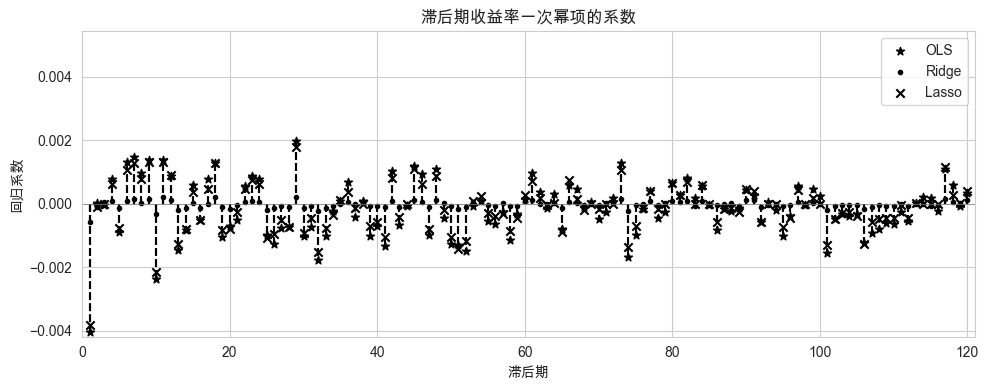

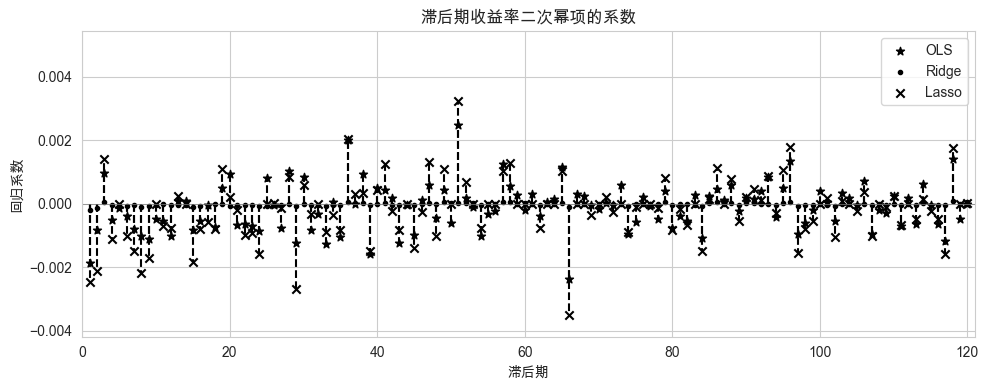

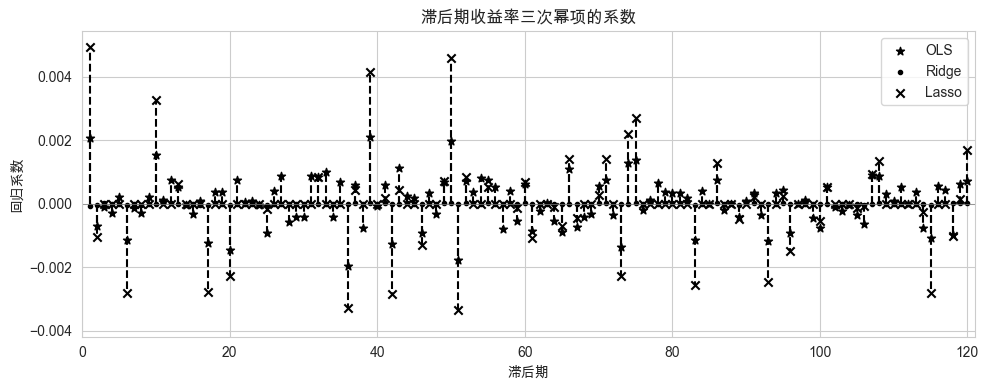

In [50]:
# 绘制估计系数规模
def plot_coefficiet_scales_2(*all_coefficients):
    
    for i, l in zip(range(0, 360, 120), ['一', '二', '三']):
        for coefficients, mk, lb in zip(all_coefficients, ['*', '.', 'x'], ['OLS', 'Ridge', 'Lasso']):
            coefficients = coefficients.values if isinstance(coefficients, pd.Series) else coefficients
            
            plt.scatter(range(1, 121), coefficients[i: i+120], color='k', marker=mk, label=lb)

            # 绘制点到x轴的连线
            for j in range(1, 121):
                plt.plot([j, j], [0, coefficients[j+i-1]], color='k', linestyle='--')

        plt.ylim((coefficients[:].min() * 1.1, coefficients[:].max() * 1.1))
        plt.xlim((0, 121))
        plt.axhline(y=0, color='gray', linewidth=.5)
        plt.title(f'滞后期收益率{l}次幂项的系数', size=12)
        plt.xlabel('滞后期')
        plt.ylabel('回归系数')
        plt.tight_layout()
        plt.grid(True)
        plt.legend()
        plt.show()

    
# 绘制 OLS 全训练样本内估计系数规模
plot_coefficiet_scales_2(
    ols_reg.params.values, 
    grid_search_4.best_estimator_.coef_,
    grid_search_lasso.best_estimator_.coef_, 
)

交互作用

* 深度神经网络；非线性主要形式为交互作用（Chen, Pelger, & Zhu, 2019）
* 神经网络、回归树；非线性主要形式为交互作用，而非单一变量自身的非线性变换（Gu, Kelly, and Xiu, 2020）
* 决策树；树结点投资者组合捕捉特征高阶交互作用，可解释（1）收益率差异（2）风险差异（Bryzgalova, Pelger, & Zhu, 2019）
* 只用历史收益率，交互作用依然存在（Moritz and Zimmermann, 2016）